In [6]:
%pylab nbagg

Populating the interactive namespace from numpy and matplotlib


## Assignment 3

## Problem 2

### Read initial abundance file
In order to make the initial abundance file readable I edit it:
* replace `PROT` with `h  1`
* remove all lines that I do not need
* remove final trailing empty line

In [38]:
#f.close()
f=open('iniab1.4E-02As09.ppn')

In [39]:
ind=[];elem=[];A=[];X=[]
i=0
for line in f.readlines():
    a,b,c,d=line.split()
    i += 1         # the first column in the file contains the charge 
    ind.append(i)  # number; we don't need it, but an index variable 
    elem.append(b) # would be useful
    A.append(c)
    X.append(d)

In [40]:
# read ini abund tester
for i in range(len(ind)):
    print ind[i],elem[i],A[i],X[i]

1 h 1 7.1538567255E-01
2 he 4 2.7025513111E-01
3 c 12 2.4825306734E-03
4 c 13 3.0083012115E-05
5 n 14 7.3396723494E-04
6 n 15 1.8049744286E-06


### RHS of network


I number reactions in the following way:

array index | reaction
------------|---------
0 |$^{12}\mathrm{C}+\mathrm{p} \rightarrow ^{13}\mathrm{N}+\mathrm{\gamma}$ followed immediately by the $\beta$ decay of $^{13}\mathrm{N}$ to $^{13}\mathrm{C}$
1 | $^{13}\mathrm{C}+\mathrm{p} \rightarrow ^{14}\mathrm{N}+\mathrm{\gamma}$ and
2 |$^{14}\mathrm{N}+\mathrm{p} \rightarrow ^{15}\mathrm{O}+\mathrm{\gamma}$ followed immediately by the $\beta$ decay of $^{15}\mathrm{O}$ to $^{15}\mathrm{N}$
3 | $^{15}\mathrm{N}+ \mathrm{p} \rightarrow ^{12}\mathrm{C}+\mathrm{\alpha}$ which closes the CN cycle.

The rates $<\sigma v>$ will be held in an array rate with length 4. In order to save time I will read off the values from the online tables. I 

In [41]:
NA=6.02214129E23  # Avoggadro number
global rate

rate=[7.36E-06]       # C12(p,g)
rate.append(3.52E-05) # C13(p,g)
rate.append(2.36E-07) # N14(p,g)
rate.append(2.03E-02) # N15(p,a)

rate = array(rate)/NA
print rate
# we can see from the large difference in value for the
# rates that this set of ODEs is stiff; it may
# require short time steps, or an implicit solution scheme


[  1.22215665e-29   5.84509700e-29   3.91887185e-31   3.37089401e-26]


I use as a template the RHS function provided in the stellar structure integration problem in Lecture_10 notebook.

Before I start I remind myself of the order of species in my species array:

In [42]:
# this is the indexing of the abundance vector y, X, Y:
for i in ind:
    print i-1, elem[i-1], A[i-1]

0 h 1
1 he 4
2 c 12
3 c 13
4 n 14
5 n 15


In [43]:
def react_terms(y):
    terms=[]
    terms.append(rate[0]*y[2]*y[0]) # 0 C12(p,g)
    terms.append(rate[1]*y[3]*y[0]) # 1 C13(p,g)
    terms.append(rate[2]*y[4]*y[0]) # 2 N14(p,g)
    terms.append(rate[3]*y[5]*y[0]) # 3 N15(p,a)
    return array(terms)

In [44]:
def f_rhs(y,t):
    '''Provide RHS for CN network equations''' 

    terms = react_terms(y)

    dh1_dt  =  -terms.sum()
    dhe4_dt =   terms[3]
    dc12_dt =  -terms[0] + terms[3]
    dc13_dt =  -terms[1] + terms[0]
    dn14_dt =  -terms[2] + terms[1]
    dn15_dt =  -terms[3] + terms[2]
    
    return [dh1_dt,dhe4_dt,dc12_dt,dc13_dt,dn14_dt,dn15_dt]

To integrate I will first try integrate.odeint from the scipy package as in Lecture 10. The time scale for this exponential decay will be of order $1/(Y \times rate \times \rho )$ in s

In [45]:
rho = 100. #cgs
1./(1.e-2*rate[1]*NA*rho) #in seconds

28409.090909090908

In [46]:
# intial conditions in right units:
X=array(X,float)
A=array(A,float)
N0=(X/A)*rho*NA
marks=['-o','--s','-^','--h','--o','-s']

In [47]:
# initial number density for all species:
print N0


[  4.30815360e+25   4.06878646e+24   1.24584587e+22   1.39357038e+20
   3.15718171e+21   7.24654069e+18]


In [58]:
# tester react_terms:
y0=array(X,dtype=float)
terms = react_terms(N0)
terms[0], rate[0], N0[0], N0[2]

(6.5596757160714916e+18,
 1.2221566458796918e-29,
 4.3081535969377734e+25,
 1.2458458726644704e+22)

In [59]:
# tester f_rhs
f_rhs(N0,t)

[-1.7487566627063853e+19,
 1.0523664910810798e+19,
 3.9639891947393065e+18,
 6.2087527362931384e+18,
 2.9761995937514355e+17,
 -1.0470361890407588e+19]

In [91]:
def integrate_netw(f_rhs,N0,t):
    '''Integrate network 
    
    Parameters:
    -----------
    f_rhs : function
        network RHS
    
    N0 : array, float
        initial abundance array, number densities
    
    t : array, float
        time step array
    
    '''
    from scipy import integrate
    N=integrate.odeint(f_rhs,N0,t)
    X=[]  # extract final output in mass fraction
    for i in ind:
    # X = Y*A = A*N/(rho*Na)
        X.append(N.transpose()[i-1]*A[i-1]/(rho*NA))
    print("Final abundance H: ",X[0][-1])
    return X

In [92]:
steps=10000
t=linspace(0.01,2.e3,steps)  
X=integrate_netw(f_rhs,N0,t)

('Final abundance H: ', 0.71512315344137023)


<IPython.core.display.Javascript object>


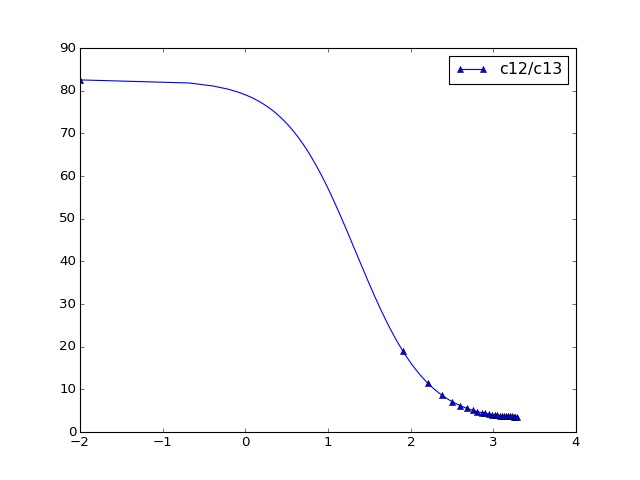

In [93]:
def plot_ratio(i,j,logy=False):
    '''
    plot ratio of species in abundance array with index i by j
    '''
    this_label = str(elem[i])+str(int(A[i]))+'/'+str(elem[j])+str(int(A[j]))
    if logy:
        yaxis=log10(X[i]/X[j])
    else:
        yaxis=X[i]/X[j]
    plot(log10(t),yaxis,marks[i],label=this_label,markevery=steps/25)
    legend(loc=0)

            
def new_figure(ifig=1):
    '''
    initialize new figure
    
    if optional figure number is provided, close first then reopen
    '''
    if type(i) is int:
        close(ifig);figure(ifig)
    else:
        figure()

new_figure()
plot_ratio(2,3)

<IPython.core.display.Javascript object>


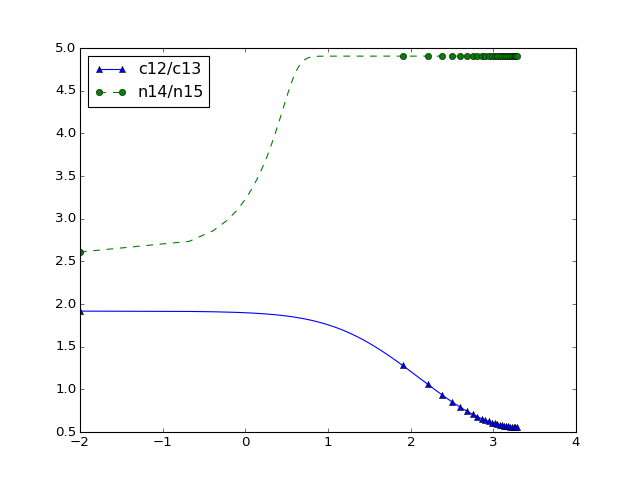

In [94]:
new_figure(ifig=2)
plot_ratio(2,3,logy=True)
plot_ratio(4,5,logy=True)

<IPython.core.display.Javascript object>


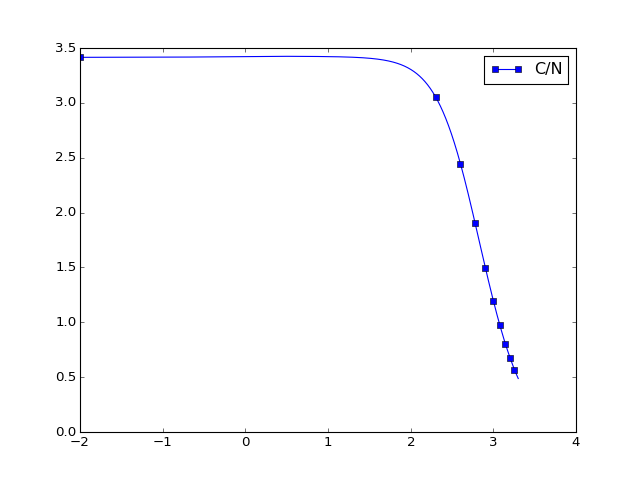

In [95]:
new_figure(ifig=3)
yaxis=(X[2]+X[3])/(X[4]+X[5])
plot(log10(t),yaxis,marks[5],label='C/N',markevery=steps/10)
legend(loc=0)

**Answer 1:** The equillibrium state involves $^{14}N$ to become the most abundant CN isotope.
The elemental ratio C/N decreases to $0.03$. The $^{12}C/^{13}C$ ratio decreases to $\approx 4$ and the N isotopic ratio reaces almost $10^5$.

In [99]:
steps=10000
t=linspace(0.001,1.e3,steps) 
X=integrate_netw(f_rhs,N0,t)

('Final abundance H: ', 0.71523891440327081)


<IPython.core.display.Javascript object>


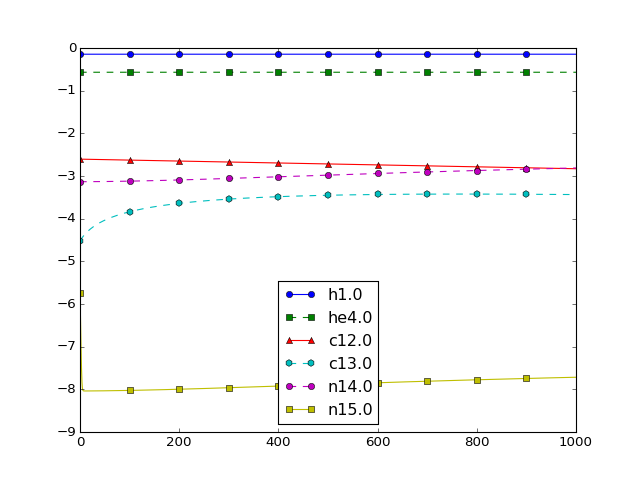

In [102]:
new_figure(ifig=4)
for i in range(len(X)):
    plot(t,log10(X[i]),marks[i],label=str(elem[i])+str(A[i]),markevery=steps/10)
legend(loc=0)

**Answer 2:** The equillibrium state is certainly reached by $10,000\mathrm{s}$.


In [138]:
steps=20
t=linspace(0,1.e7,steps)
X=integrate_netw(f_rhs,N0,t)
from prettytable import PrettyTable
xx = PrettyTable(t,array(X).T)

('Final abundance H: ', 0.56365905972697494)


ImportError: No module named prettytable

In [130]:
ind_H0p9=max(where(X[0]>X[0][0]*0.9)[0])
print "Answer 3:"
print "10% H1 is burnt after "+str(t[ind_H0p9]/3.14e7)+"yr."

Answer 3:
10% H1 is burnt after 0.0yr.


<IPython.core.display.Javascript object>


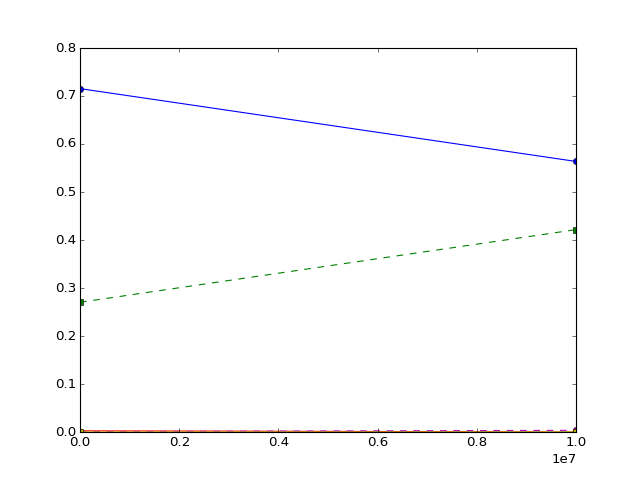

In [132]:
new_figure(ifig=5)

# check answer visually
marks=['-o','--s','-^','--h','--o','-s']
for i in range(len(X)):
    plot(t,X[i],marks[i],label=str(elem[i])+str(A[i]),markevery=steps/steps)
